In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import torch
import time
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [2]:
N = 1e6

all_features = "v0_ks_mass v0_ks_massErr pv0_x pv0_y pv0_z a0xy a0 a0z cosTheta v0_chi2 \
v0_x v0_y v0_z v0_rxy v0_rxyErr v0_px v0_py v0_pz v0_pt v0_p \
v0_ptErr \
v0_px1 v0_py1 v0_pz1 v0_pt1 \
v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 \
v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 \
epsilon2 Alpha pL1 pL2 pT thetastar rapidity_ks pseudorapidity".split(" ")

# path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
# file = uproot.open(path)
# data = file['tree'].pandas.df(all_features, entrystop = N)

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(all_features + ['trueKs','trueLa','trueLb'], entrystop = N)

# data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
# train_test_slice = int(len(data)*0.8)
# train_data = data[:train_test_slice]
# test_data = data[train_test_slice:]

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)]
train_test_slice = int(len(mc)*0.8)
train_set = mc[:train_test_slice]
test_set = mc[train_test_slice:]

In [3]:
feats = "v0_rxy v0_rxyErr cosTheta".split(" ")

In [4]:
# scaler = StandardScaler()
# train_set[feats] = scaler.fit_transform(train_set[feats]).astype(np.float32)
# test_set[feats] = scaler.transform(test_set[feats]).astype(np.float32)

In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.inc = len(feats)
        self.outc = 4
        self.hcs = 20
        num_layers = 5
        self.act = torch.nn.Tanhshrink()
        
        self.lin_in = torch.nn.Linear(self.inc,self.hcs)
        self.lin_out = torch.nn.Linear(self.hcs,self.outc)
        self.lins = torch.nn.ModuleList()
        for i in range(num_layers):
            self.lins.append(torch.nn.Linear(self.hcs,self.hcs))
    
    def forward(self,data):
        
        data = self.lin_in(data)
        
        for lin in self.lins:
            data = lin(self.act(data))
        
        data = self.lin_out(self.act(data))
        
        return data

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device is', device)
model = Net().to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
crit = torch.nn.CrossEntropyLoss()

Device is cuda


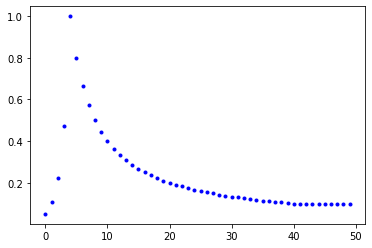

In [7]:
def lambda_lr(epoch,epoch_warmup=5,max=50,a=0.05,q=0.1):
    if epoch < epoch_warmup:
        return a**(1-epoch/epoch_warmup)
    elif epoch < max*epoch_warmup:
        return 1/(1 + (1/q-1)*(epoch/epoch_warmup - 1)/(max-1))
    else:
        return q

x = np.arange(0,50)
fig ,ax = plt.subplots()
ax.plot(x,[lambda_lr(i,4,10) for i in x],'b.');

In [8]:
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,lambda_lr)

In [9]:
class DF_dataset(torch.utils.data.Dataset):
    def __init__(self,df,y):
        self.df = torch.tensor(df.values).float()
        self.y = torch.tensor(y.values,dtype=torch.long).squeeze()
    
    def __len__(self): return len(self.y)
    
    def __getitem__(self,idx):
        return [self.df[idx],self.y[idx]]

In [10]:
batch_size = 1024
y_train = train_set.trueKs+2*train_set.trueLa+3*train_set.trueLb
y_test = test_set.trueKs+2*test_set.trueLa+3*test_set.trueLb
train_loader = torch.utils.data.DataLoader(DF_dataset(train_set[feats],y_train),batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(DF_dataset(test_set[feats],y_test),batch_size=batch_size,shuffle=True)

In [11]:
def cal_acc(output,label):
    return output.argmax(dim=1).eq(label).float().mean().item()

In [12]:
batch_acc, batch_loss = [], []
def train():
    model.train()
    for data in train_loader:
        x = data[0].to(device)
        y = data[1].to(device).squeeze()
        optimizer.zero_grad()
        output = model(x)
        loss = crit(output,y)
        loss.backward()
        optimizer.step()        
        batch_acc.append(cal_acc(output,y))
        batch_loss.append(loss.item())
        del x,y
    torch.cuda.empty_cache()

In [16]:
def test():
    probs = np.array([])
    truths = np.array([])
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            prob = torch.nn.Softmax(dim=1)(model(data[0].to(device))).cpu().numpy()
            probs = np.append(probs,prob)
            truths = np.append(truths,data[1].to(device).squeeze().cpu().numpy())
    return probs, truths

In [14]:
def epochs(i):
    print('Begins training')
    t0 = time.time()
    for epoch in range(i):
        print(f'Epoch: {epoch}')
        train()
        scheduler.step() if scheduler else None
        print(f'time since beginning: {time.time() - t0}')

In [15]:
epochs(10)

Begins training
Epoch: 0
time since beginning: 12.330702066421509
Epoch: 1
time since beginning: 24.35075354576111
Epoch: 2
time since beginning: 36.44066524505615
Epoch: 3
time since beginning: 48.52092719078064
Epoch: 4
time since beginning: 60.66699552536011
Epoch: 5
time since beginning: 72.74885487556458
Epoch: 6
time since beginning: 84.82117223739624
Epoch: 7
time since beginning: 97.06090211868286
Epoch: 8
time since beginning: 109.08172178268433
Epoch: 9
time since beginning: 121.28277945518494


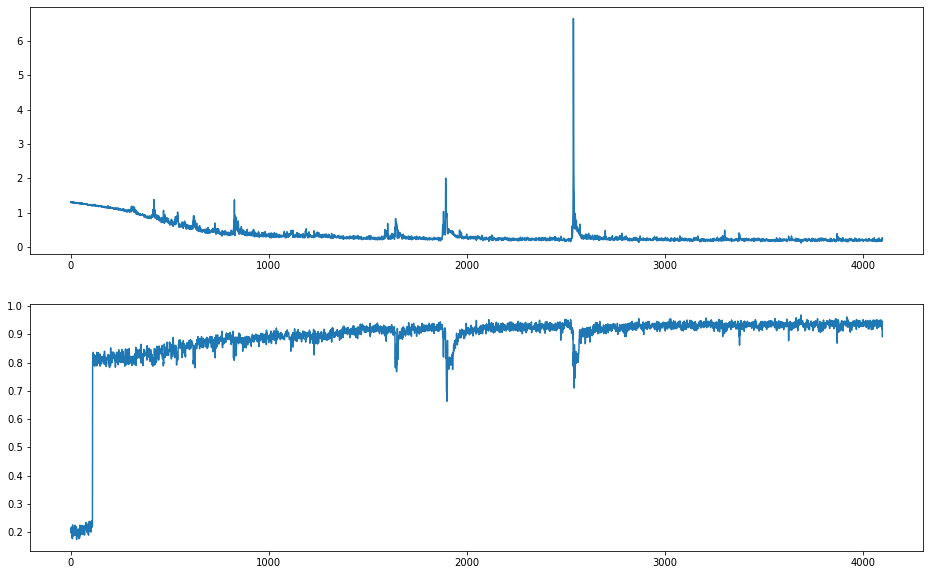

In [17]:
fig, ax = plt.subplots(figsize=(16,10),nrows=2)

ax[0].plot(batch_loss)
ax[1].plot(batch_acc)

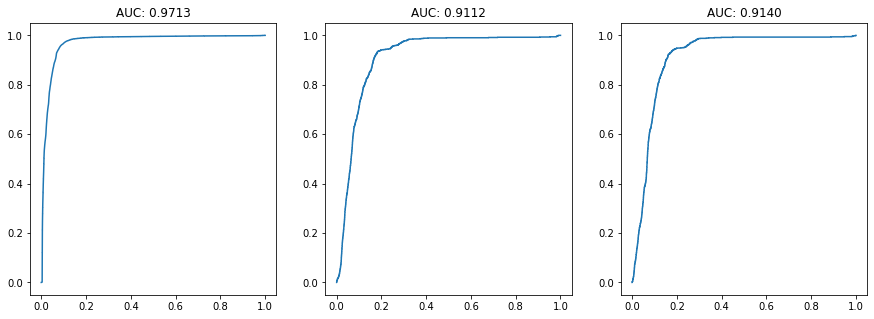

In [33]:
scores, truths = test()
scores = scores.reshape(-1,4)

fig, ax = plt.subplots(ncols=3,nrows=1,figsize=(15,5))
ax = ax.flatten()

for i in range(1,4):
    fpr,tpr,treshhold = roc_curve(truths == i,scores[:,i])
    auc = roc_auc_score(truths == i,scores[:,i])
    ax[i-1].plot(fpr,tpr)
    ax[i-1].set_title(f'AUC: {auc:.4f}')

Text(0.5, 1.0, 'AUC: 0.9769')

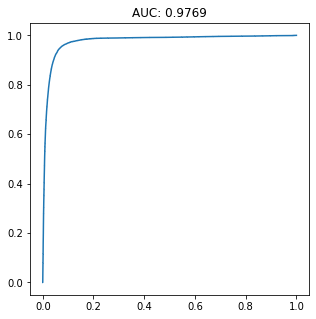

In [49]:
scores, truths = test()
fig, ax = plt.subplots(figsize=(5,5))
fpr,tpr,treshhold = roc_curve(truths,scores)
auc = roc_auc_score(truths,scores)
ax.plot(fpr,tpr,label='simple NN')
ax.set_title(f'AUC: {auc:.4f}')

In [50]:
import xgboost as xgb
cla = xgb.XGBClassifier()
cla.fit(train_set[feats],train_set[y])
p = cla.predict_proba(test_set[feats])[:,1]

C:\Users\jv97\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jv97\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


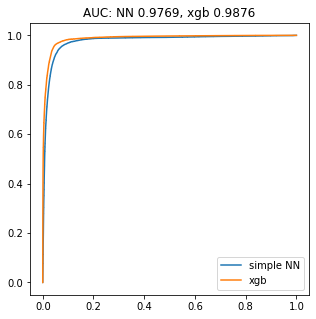

In [51]:
f,t,thh = roc_curve(test_set[y],p)
a = roc_auc_score(test_set[y],p)
ax.plot(f,t,label='xgb')
ax.set_title(f'AUC: NN {auc:.4f}, xgb {a:.4f}')
ax.legend()
fig